In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [2]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Change the billboard_observation_date!

In [3]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2024-04-16'

In [4]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [5]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [6]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [7]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
# from upload.rank_by_name import rankings
from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

["Texas Hold 'Em",
 'I Remember Everything',
 'Man Made A Bar',
 'II Most Wanted',
 'Austin',
 '...',
 'My Rose',
 'Deeper Well',
 'Love You Again',
 "I'm Not Pretty",
 'Young Love & Saturday Nights']

In [8]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [9]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:---------------|:--------------|:--------------------|---------------------------:|
| 93 |       116 | Texas Hold 'Em | Beyonce       | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name             | artist_name     | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------------|:----------------|:--------------------|---------------------------:|
|   0 |         1 | I Remember Everything | Kacey Musgraves | Featured artist     |                         21 |
| 134 |         1 | I Remember Everything | Zach Bryan      | Lead artist         |                         21 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name      | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:---------------|:--------------|:--

Please enter the song_id or 'New Song'

|    |   song_id | song_name           | artist_name    | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:--------------------|:---------------|:--------------------|---------------------------:|
| 16 |        30 | Wind Up Missin' You | Tucker Wetmore | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 10 |        24 | Bulletproof | Nate Smith    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 77 |        98 | We Ride     | Bryan Martin  | Lead

Please enter the song_id or 'New Song'



In [10]:
# Notes
# s2a for Burn It Down

In [13]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

44 +
['Daughter', 'Ameriican Requiem', 'Protector', 'Alliigator Tears', 'Just For Fun', 'My Rose']


### Add artists on any new songs that aren't in the artist table yet to its CSV

In [14]:
df_artist = pd.read_csv('source_data/artist.csv')

'Daughter': Beyonce(3)
, 'Ameriican Requiem': Beyonce(3)
, 'Protector': Beyonce(3) & Rumi Carter(84)
, 'Alliigator Tears': Beyonce(3)
, 'Just For Fun': Beyonce(3) & Willie Jones(85)
, 'My Rose': Beyonce(3)
[s2a only] Burn It Down: Parker McCollum(86) +30

In [15]:
new_song_artists = [
    'Rumi Carter'
    , 'Willie Jones'
    , 'Parker McCollum'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update


In [16]:
df_artist['artist_id'].max()

83

In [17]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [84, 'Rumi Carter', 1, current_date]
                , [85, 'Willie Jones', 0, current_date]
                , [86, 'Parker McCollum', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [18]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-16


### Add all new songs to the song table CSV

In [19]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [20]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[159, 'Daughter', 0, '2024-09-15'],
 [160, 'Ameriican Requiem', 0, '2024-09-15'],
 [161, 'Protector', 0, '2024-09-15'],
 [162, 'Alliigator Tears', 0, '2024-09-15'],
 [163, 'Just For Fun', 0, '2024-09-15'],
 [164, 'My Rose', 0, '2024-09-15']]

In [21]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
157,158,Riiverdance,0.0,2024-09-15
158,159,Daughter,0,2024-09-15
159,160,Ameriican Requiem,0,2024-09-15
160,161,Protector,0,2024-09-15
161,162,Alliigator Tears,0,2024-09-15
162,163,Just For Fun,0,2024-09-15
163,164,My Rose,0,2024-09-15


'Daughter': Beyonce(3)
, 'Ameriican Requiem': Beyonce(3)
, 'Protector': Beyonce(3) & Rumi Carter(84)
, 'Alliigator Tears': Beyonce(3)
, 'Just For Fun': Beyonce(3) & Willie Jones(85)
, 'My Rose': Beyonce(3)
[s2a only] Burn It Down: Parker McCollum(86) +30

In [21]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    #(157, 15)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [22]:
# df_song_raw[df_song_raw['song_name'].isin(['Burn It Down'])]

,song_id,song_name,untracked_weeks_on_chart,last_update
13,14,Burn It Down,30.0,2024-8-23


In [23]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
157,158,Riiverdance,0.0,2024-09-15
158,159,Daughter,0,2024-09-15
159,160,Ameriican Requiem,0,2024-09-15
160,161,Protector,0,2024-09-15
161,162,Alliigator Tears,0,2024-09-15
162,163,Just For Fun,0,2024-09-15
163,164,My Rose,0,2024-09-15


In [24]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-16


#### Add all new songs to the song_to_artist table CSV

In [25]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

'Daughter': Beyonce(3)
, 'Ameriican Requiem': Beyonce(3)
, 'Protector': Beyonce(3) & Rumi Carter(84)
, 'Alliigator Tears': Beyonce(3)
, 'Just For Fun': Beyonce(3) & Willie Jones(85)
, 'My Rose': Beyonce(3)
[s2a only] Burn It Down: Parker McCollum(86) +30

In [26]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [159, 3, '', '']
    , [160, 3, '', '']
    , [161, 3, '', '']
    , [161, 84, '&', 1]
    , [162, 3, '', '']
    , [163, 3, '', '']
    , [163, 85, '&', 1]
    , [164, 3, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['159-Lead artist-', 159, 3, 'Lead artist', '', '', '2024-09-15'],
 ['160-Lead artist-', 160, 3, 'Lead artist', '', '', '2024-09-15'],
 ['161-Lead artist-', 161, 3, 'Lead artist', '', '', '2024-09-15'],
 ['161-Other main artist-1',
  161,
  84,
  'Other main artist',
  '&',
  1,
  '2024-09-15'],
 ['162-Lead artist-', 162, 3, 'Lead artist', '', '', '2024-09-15'],
 ['163-Lead artist-', 163, 3, 'Lead artist', '', '', '2024-09-15'],
 ['163-Other main artist-1',
  163,
  85,
  'Other main artist',
  '&',
  1,
  '2024-09-15'],
 ['164-Lead artist-', 164, 3, 'Lead artist', '', '', '2024-09-15']]

In [27]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
198,164-Lead artist-,164,3,Lead artist,,,2024-09-15


In [28]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2024-04-16


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [29]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2024-04-16-33', '2024-04-16', 33, 160, '2024-09-15'],
 ['2024-04-16-36', '2024-04-16', 36, 161, '2024-09-15'],
 ['2024-04-16-41', '2024-04-16', 41, 162, '2024-09-15'],
 ['2024-04-16-43', '2024-04-16', 43, 163, '2024-09-15'],
 ['2024-04-16-46', '2024-04-16', 46, 164, '2024-09-15']]

In [30]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2024-04-16


## Push to duckdb

In [31]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [32]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

In [33]:
weeks_lookback = 13 # Arbitrary lookback

with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(sql_file.read().format(weeks_ago = str(weeks_ago)))
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [34]:
# TODO make this show NA() for lookback windows with zero artist song credits
df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -3:][:30]

weeks_ago,-3,-2,-1,0
artist_name,,,,
Zach Bryan,1,1,1,1
Post Malone,10,4,2,2
Morgan Wallen,2,2,3,3
Beyonce,3,3,4,4
Megan Moroney,4,5,5,5
Jelly Roll,5,6,6,6
Luke Combs,6,7,7,7
Bailey Zimmerman,7,8,8,8
Tucker Wetmore,8,9,9,9


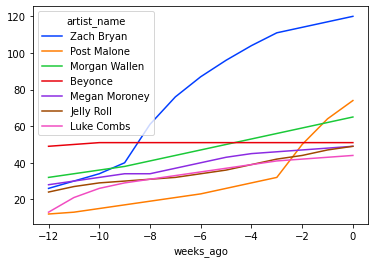

In [35]:
graph = sns.lineplot(
    data = df_artist_ranking.pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = 'recent_weeks_main_artist'
      ).loc[
        df_artist_ranking_over_time[0].keys() # maintain order from rank
      ][:7].fillna(np.inf).T
    , dashes = False
    #, markers = ['.'] * n_cols # TODO define new cols
    , palette = 'bright'
)
# title = 'Number of weeks as main artist'
# size = scale up plot size, then scale up number of lines

In [36]:
# Current artist rankings
pd.set_option('display.max_rows', 100)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact.loc[ :, 1 : len(cols) - 2 ][df_artist_ranking['weeks_ago'] == 0]

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Zach Bryan,0,120,120,120,159,159,159,22,22,22,22,22,22,2.0,2.0,2.0,2,2024-04-16
1,Post Malone,0,70,74,74,70,74,74,19,20,20,19,20,20,1.0,1.0,1.0,1,2024-04-16
2,Morgan Wallen,0,43,65,77,77,99,111,4,6,7,4,6,7,1.0,1.0,1.0,1,2024-04-16
3,Beyonce,0,51,51,51,51,51,51,14,14,14,14,14,14,1.0,1.0,1.0,1,2024-04-16
4,Megan Moroney,0,44,49,49,64,73,73,5,6,6,5,6,6,21.0,21.0,21.0,21,2024-04-16
5,Jelly Roll,0,32,49,73,34,66,91,5,7,9,5,7,9,7.0,7.0,7.0,7,2024-04-16
6,Luke Combs,0,44,44,52,92,92,100,9,9,11,10,10,12,3.0,3.0,3.0,3,2024-04-16
7,Bailey Zimmerman,0,39,39,39,45,45,45,4,4,4,4,4,4,6.0,6.0,6.0,6,2024-04-16
8,Tucker Wetmore,0,37,37,37,37,37,37,3,3,3,3,3,3,11.0,11.0,11.0,11,2024-04-16
9,Dylan Scott,0,23,35,35,31,49,49,2,3,3,2,3,3,35.0,35.0,35.0,35,2024-04-26


In [38]:
with duckdb.connect('raw_db.duckdb') as conn:
    print(conn.sql(
        """
        SELECT billboard_observation_date, COUNT(1) n
        FROM raw_db.billboard.billboard_ranking
        GROUP BY 1
        ORDER BY 1 DESC
        """
    ))

┌────────────────────────────┬───────┐
│ billboard_observation_date │   n   │
│            date            │ int64 │
├────────────────────────────┼───────┤
│ 2024-09-10                 │    50 │
│ 2024-09-05                 │    50 │
│ 2024-08-27                 │    50 │
│ 2024-08-23                 │    50 │
│ 2024-08-13                 │    50 │
│ 2024-08-07                 │    50 │
│ 2024-07-31                 │    50 │
│ 2024-07-23                 │    50 │
│ 2024-07-16                 │    50 │
│ 2024-07-10                 │    50 │
│ 2024-07-02                 │    50 │
│ 2024-06-25                 │    50 │
│ 2024-06-18                 │    50 │
│ 2024-06-11                 │    50 │
│ 2024-06-04                 │    50 │
│ 2024-05-29                 │    50 │
│ 2024-05-21                 │    50 │
│ 2024-05-15                 │    50 │
│ 2024-05-08                 │    50 │
│ 2024-04-30                 │    50 │
│ 2024-04-26                 │    50 │
├────────────────────────

In [39]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2024-06-18' # TODO

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬───────────────────────────┬────────────────┐
│ song_id │         song_name         │ ranking_before │
│  int32  │          varchar          │     int32      │
├─────────┼───────────────────────────┼────────────────┤
│      38 │ I Had Some Help           │              1 │
│      43 │ Pink Skies                │              3 │
│      37 │ Miles On It               │              7 │
│      47 │ High Road                 │              8 │
│      40 │ Ain't No Love In Oklahoma │              9 │
│      41 │ Sweet Dreams              │             10 │
│     109 │ The Man He Sees In Me     │             16 │
│      94 │ Purple Gas                │             19 │
│      39 │ Beautiful As You          │             26 │
│      42 │ Hang Tight Honey          │             27 │
│      48 │ I Am Not Okay             │             32 │
│      72 │ Indifferent               │             40 │
│      45 │ Wanna Be Loved            │             41 │
│      93 │ Boys Back Home     

# Scratch work to get song sparklines

In [ ]:
# TODO add a measurement start date column for Friday of each week based on observation date

In [46]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [37]:
%%sql df_a_song <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
WHERE br.song_id IN (63, 64) -- # Out Of Oklahoma, Guy For That as examples
ORDER BY 1 ASC
;

In [43]:
df_a_song

,billboard_observation_date,song_id,song_name,billboard_rank
0,2024-07-31,63,Out Of Oklahoma,45
1,2024-08-07,64,Guy For That,7
2,2024-08-07,63,Out Of Oklahoma,43
3,2024-08-13,64,Guy For That,12
4,2024-08-13,63,Out Of Oklahoma,41
5,2024-08-23,64,Guy For That,12
6,2024-08-23,63,Out Of Oklahoma,40
7,2024-08-27,64,Guy For That,7
8,2024-09-05,64,Guy For That,11
9,2024-09-10,64,Guy For That,12


In [44]:
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet

In [45]:
df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf)

song_name,Guy For That,Out Of Oklahoma
billboard_observation_date,,
2024-07-31,inf,45.0
2024-08-07,7.0,43.0
2024-08-13,12.0,41.0
2024-08-23,12.0,40.0
2024-08-27,7.0,inf
2024-09-05,11.0,inf
2024-09-10,12.0,50.0


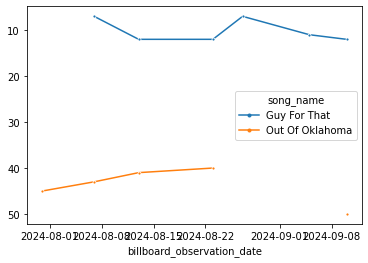

In [53]:
n_lines = 2 # TODO use df.count()

# TODO scale up size
# TODO a line for every song by an artist
# TODO loop through artists
# TODO dash type based on s2a relationship type
graph = sns.lineplot(
    data = df_a_song.pivot(
        index='billboard_observation_date'
        , columns='song_name'
        , values='billboard_rank'
    ).fillna(np.inf) # hide hidden data // TODO: show points with null immediately before and after
    , markers=['.'] * n_lines
    , dashes=False
    # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
)
graph.axes.invert_yaxis()

In [38]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

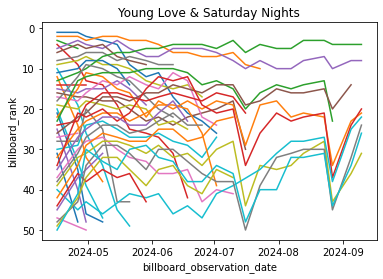

In [39]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(np.inf)
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        , markers='.' # TODO: fix to show points with null immediately before and after
        , dashes=False
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    ).set_title(this_song.reset_index()['song_name'][0])
    
graph.axes.invert_yaxis()
# TODO: verticalize x-axis labels
# TODO: Make this about 4x bigger

In [112]:
# TODO: Each song on its own tile, rather than overlapped

In [ ]:
# NOW IS A GREAT TIME TO GET ALL BEYONCE SONGS instead of all from current week